__<center><font size="6.5"> Early Detection and Mitigation of Financial Risks in Home Health Agencies: <br>A CMS Intervention Approach.<br></font>__ <br>

In [55]:
#Standard libraries for data analysis:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# sklearn modules for data preprocessing:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

#sklearn modules for Model Selection:
from sklearn import svm, tree, linear_model, neighbors
from sklearn import naive_bayes, ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#sklearn modules for Model Evaluation & Improvement:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import auc, roc_auc_score, roc_curve, classification_report
import math

# seaborn plotting
import seaborn as sn
from sklearn.tree import plot_tree

import warnings
warnings.simplefilter("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [23]:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/Sharedrives/Machine Learning')

### Exploratory Data Analysis

In [2]:
HHA_Cost = pd.read_csv('HHA_Cost_Report_2021.csv', index_col=None)
print(HHA_Cost.shape)
HHA_Date = HHA_Cost.loc[:,['Provider CCN','Fiscal Year Begin Date','Fiscal Year End Date']]
HHA_Date['Date Range'] = HHA_Date['Fiscal Year Begin Date'] + " - " + HHA_Date['Fiscal Year End Date']
HHA_Date = HHA_Date.sort_values(by = 'Fiscal Year Begin Date', ascending = True)
Date_Ranges = HHA_Date.groupby(['Date Range']).count()
Date_Ranges.drop(columns = ['Fiscal Year Begin Date','Fiscal Year End Date'], inplace = True)
Date_Ranges = Date_Ranges.sort_values(by = 'Provider CCN', ascending = False)
Date_Ranges.head()

(10361, 201)


,Provider CCN
Date Range,
2021-01-01 - 2021-12-31,8455
2021-07-01 - 2022-06-30,530
2020-10-01 - 2021-09-30,309
2021-09-01 - 2022-08-31,73
2021-04-01 - 2022-03-31,62


In [3]:
Date_Ranges = Date_Ranges.reset_index()
Date_Ranges[['Fiscal Year Begin Date','Fiscal Year End Date']] = Date_Ranges['Date Range'].str.split(' - ', expand = True)
Date_Ranges[['Fiscal Year Begin Date','Fiscal Year End Date']]= Date_Ranges.loc[:,['Fiscal Year Begin Date','Fiscal Year End Date']].apply(pd.to_datetime, errors='coerce')
Date_Ranges.head()

,Date Range,Provider CCN,Fiscal Year Begin Date,Fiscal Year End Date
0,2021-01-01 - 2021-12-31,8455,2021-01-01,2021-12-31
1,2021-07-01 - 2022-06-30,530,2021-07-01,2022-06-30
2,2020-10-01 - 2021-09-30,309,2020-10-01,2021-09-30
3,2021-09-01 - 2022-08-31,73,2021-09-01,2022-08-31
4,2021-04-01 - 2022-03-31,62,2021-04-01,2022-03-31


In [4]:
def CountDays(column):
    dayscount = abs(column.loc[:,'Fiscal Year Begin Date'] - column.loc[:,'Fiscal Year End Date']) /np.timedelta64(1,'D')
    return dayscount
Date_Ranges['Days_Count'] = CountDays(Date_Ranges)
Date_Ranges = Date_Ranges[Date_Ranges.loc[:,'Days_Count'] > 350]
Date_Ranges.head(5)

,Date Range,Provider CCN,Fiscal Year Begin Date,Fiscal Year End Date,Days_Count
0,2021-01-01 - 2021-12-31,8455,2021-01-01,2021-12-31,364.00
1,2021-07-01 - 2022-06-30,530,2021-07-01,2022-06-30,364.00
2,2020-10-01 - 2021-09-30,309,2020-10-01,2021-09-30,364.00
3,2021-09-01 - 2022-08-31,73,2021-09-01,2022-08-31,364.00
4,2021-04-01 - 2022-03-31,62,2021-04-01,2022-03-31,364.00


In [5]:
Date_Ranges[Date_Ranges.loc[:,'Days_Count'] > 365].shape
Date_Ranges.shape
Date_Ranges.loc[:,'Provider CCN'].sum()

9675

In [6]:
# subset frame based on 70 date ranges
HHA_Date = HHA_Date[HHA_Date['Date Range'].isin(list(Date_Ranges['Date Range'].values))]
HHA_Date.head()

,Provider CCN,Fiscal Year Begin Date,Fiscal Year End Date,Date Range
776,57571,2020-10-01,2021-09-30,2020-10-01 - 2021-09-30
791,37265,2020-10-01,2021-09-30,2020-10-01 - 2021-09-30
2221,398239,2020-10-01,2021-09-30,2020-10-01 - 2021-09-30
2220,398213,2020-10-01,2021-09-30,2020-10-01 - 2021-09-30
278,679013,2020-10-01,2021-09-30,2020-10-01 - 2021-09-30


In [7]:
# subset Cost frame based on 9675 CCN
HHA_Cost = pd.merge(HHA_Date.drop(columns = 'Date Range'), HHA_Cost, left_on=['Provider CCN','Fiscal Year Begin Date','Fiscal Year End Date'], right_on=['Provider CCN','Fiscal Year Begin Date','Fiscal Year End Date'], how='left')
HHA_Cost['Provider CCN'] = HHA_Cost['Provider CCN'].astype(str)
HHA_ProviderOfService = pd.read_csv(r"ProviderOfService_iQIES_Mar24.csv", index_col=None)
print(HHA_ProviderOfService.shape)
HHA_Frame = pd.merge(HHA_Cost, HHA_ProviderOfService, left_on = 'Provider CCN', right_on = 'prvdr_num', how = 'left')
HHA_ProviderJuly21 = pd.read_csv('HH_Provider_July2021.csv')
print(HHA_ProviderJuly21.shape)
HHA_ProviderJuly21['CMS Certification Number (CCN)'] = HHA_ProviderJuly21['CMS Certification Number (CCN)'].astype(str)
HHA_Frame = pd.merge(HHA_Frame, HHA_ProviderJuly21, left_on = 'Provider CCN', right_on = 'CMS Certification Number (CCN)', how = 'left')
HHA_Frame.info()

(38822, 102)
(11176, 60)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9675 entries, 0 to 9674
Columns: 363 entries, Provider CCN to No. of episodes to calc how much Medicare spends per episode of care at agency, compared to spending at all agencies (national)
dtypes: float64(271), int64(1), object(91)
memory usage: 26.8+ MB


In [8]:
columns_to_keep = ['Provider CCN','HHA Name','State Code','Total, Total Visits','Total Cost','Accounts Receivable','Inventory',
'Total Current Assets','Total Assets','Accounts Payable','Total Current Liabilities','Total Liabilities','Net Patient Revenues (line 1 minus line 2) Total','Net Income or Loss for the period (line 18 plus line 32)',
'Type of Ownership','Quality of patient care star rating','How often patients breathing improved','How often patients receiving home health care needed urgent, unplanned care in the ER without being admitted',
"How much Medicare spends on an episode of care at this agency, compared to Medicare spending across all agencies nationally",'hh_aide_cnt','brnch_cnt','mdcr_hospc_sw','pgm_prtcptn_cd']
final_df = HHA_Frame[columns_to_keep]; final_df.head()

,Provider CCN,HHA Name,State Code,"Total, Total Visits",Total Cost,Accounts Receivable,Inventory,Total Current Assets,Total Assets,Accounts Payable,...,Net Income or Loss for the period (line 18 plus line 32),Type of Ownership,Quality of patient care star rating,How often patients breathing improved,"How often patients receiving home health care needed urgent, unplanned care in the ER without being admitted","How much Medicare spends on an episode of care at this agency, compared to Medicare spending across all agencies nationally",hh_aide_cnt,brnch_cnt,mdcr_hospc_sw,pgm_prtcptn_cd
0,57571,COVENANT HOME SERVICES,CA,31663.00,5814627.00,1593543.00,NaN,1992258.00,2798817.00,1046157.00,...,1527421.00,VOLUNTARY NON PROFIT - RELIGIOUS AFFILIATION,3.00,92.40,15.60,0.91,NaN,NaN,NaN,NaN
1,37265,BEATITUDES HOME HEALTH,AZ,4725.00,730909.00,99962.00,NaN,262962.00,262962.00,19122.00,...,-32002.00,VOLUNTARY NON PROFIT - RELIGIOUS AFFILIATION,3.00,59.50,7.50,1.05,NaN,NaN,NaN,NaN
2,398239,PEDIATRIC SERVICES OF AMERICA INC.,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,PROPRIETARY,NaN,NaN,NaN,NaN,1.00,0.00,False,medicare-18 medicaid-19
3,398213,PEDIATRIC SERVICES OF AMERICA INC.,PA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,PROPRIETARY,NaN,NaN,NaN,NaN,27.00,NaN,False,medicare-18 medicaid-19
4,679013,ELARA CARING,TX,3888.00,1067424.00,-4240.00,NaN,-789.00,-789.00,3907.00,...,-483528.00,PROPRIETARY,NaN,NaN,NaN,0.82,1.00,0.00,False,medicare-18 medicaid-19


In [9]:
columns_to_include = ['Total Cost','Accounts Receivable','Total, Total Visits','Total Current Assets', 'Net Income or Loss for the period (line 18 plus line 32)','Total Assets',
                      'Accounts Payable','Total Current Liabilities','Total Liabilities','Net Patient Revenues (line 1 minus line 2) Total','Inventory']


for col in final_df.columns:
    if col in columns_to_include:
        final_df[col] = final_df[col].replace({'\$': '', ',': ''}, regex=True).astype(float)

In [10]:
final_df.isnull().sum()

Provider CCN                                                                                                                      0
HHA Name                                                                                                                          0
State Code                                                                                                                        0
Total, Total Visits                                                                                                            2541
Total Cost                                                                                                                     2541
Accounts Receivable                                                                                                            4442
Inventory                                                                                                                      9183
Total Current Assets                                                        

In [11]:
# simple imputer for categorical features
imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
final_df.loc[:,['mdcr_hospc_sw','Type of Ownership','pgm_prtcptn_cd']] = final_df.loc[:,['mdcr_hospc_sw','Type of Ownership','pgm_prtcptn_cd']].apply(lambda x: imputer.fit_transform(x.values.reshape(-1,1))[:,0])

# simple imputer for continuous features
columns_to_impute = ['Total, Total Visits','Net Income or Loss for the period (line 18 plus line 32)', 'Quality of patient care star rating', "How often patients breathing improved", 'Total Cost', 'Accounts Receivable', 'Inventory', 'Total Current Assets', 'Total Assets', 'Accounts Payable',
                     'Total Current Liabilities', 'Total Liabilities','Net Patient Revenues (line 1 minus line 2) Total',"How often patients receiving home health care needed urgent, unplanned care in the ER without being admitted",
                     "How much Medicare spends on an episode of care at this agency, compared to Medicare spending across all agencies nationally",'brnch_cnt','hh_aide_cnt','mdcr_hospc_sw']

imputer = SimpleImputer(strategy='mean')
final_df[columns_to_impute] = imputer.fit_transform(final_df[columns_to_impute])

final_df.rename({'Net Income or Loss for the period (line 18 plus line 32)':'Net Income or Loss','Net Patient Revenues (line 1 minus line 2) Total':'Net Patient Revenues',
                 'Quality of patient care star rating':'Quality of Patient Care',"How often patients breathing improved":'Breathing Improvement',
                 'How often patients receiving home health care needed urgent, unplanned care in the ER without being admitted':'Urgent, unplanned care in the ER',
                 'How much Medicare spends on an episode of care at this agency, compared to Medicare spending across all agencies nationally':'Agency Medicare spends VS National Medicare spends',
                 'hh_aide_cnt':'No of HHA Employees','brnch_cnt':'No of HHA Branches',
                 'mdcr_hospc_sw':'Hospice Medicare',
                 'pgm_prtcptn_cd':'Medicare/Medicaid/Both'}, axis = 'columns', inplace = True)

final_df.head()

,Provider CCN,HHA Name,State Code,"Total, Total Visits",Total Cost,Accounts Receivable,Inventory,Total Current Assets,Total Assets,Accounts Payable,...,Net Income or Loss,Type of Ownership,Quality of Patient Care,Breathing Improvement,"Urgent, unplanned care in the ER",Agency Medicare spends VS National Medicare spends,No of HHA Employees,No of HHA Branches,Hospice Medicare,Medicare/Medicaid/Both
0,57571,COVENANT HOME SERVICES,CA,31663.00,5814627.00,1593543.00,1676225.86,1992258.00,2798817.00,1046157.00,...,1527421.00,VOLUNTARY NON PROFIT - RELIGIOUS AFFILIATION,3.00,92.40,15.60,0.91,15.87,0.37,0.00,medicare-18 medicaid-19
1,37265,BEATITUDES HOME HEALTH,AZ,4725.00,730909.00,99962.00,1676225.86,262962.00,262962.00,19122.00,...,-32002.00,VOLUNTARY NON PROFIT - RELIGIOUS AFFILIATION,3.00,59.50,7.50,1.05,15.87,0.37,0.00,medicare-18 medicaid-19
2,398239,PEDIATRIC SERVICES OF AMERICA INC.,PA,22750.46,3071628.05,17381990.30,1676225.86,19298377.92,85669142.23,2992547.56,...,428466.88,PROPRIETARY,3.29,76.20,12.69,0.97,1.00,0.00,0.00,medicare-18 medicaid-19
3,398213,PEDIATRIC SERVICES OF AMERICA INC.,PA,22750.46,3071628.05,17381990.30,1676225.86,19298377.92,85669142.23,2992547.56,...,428466.88,PROPRIETARY,3.29,76.20,12.69,0.97,27.00,0.37,0.00,medicare-18 medicaid-19
4,679013,ELARA CARING,TX,3888.00,1067424.00,-4240.00,1676225.86,-789.00,-789.00,3907.00,...,-483528.00,PROPRIETARY,3.29,76.20,12.69,0.82,1.00,0.00,0.00,medicare-18 medicaid-19


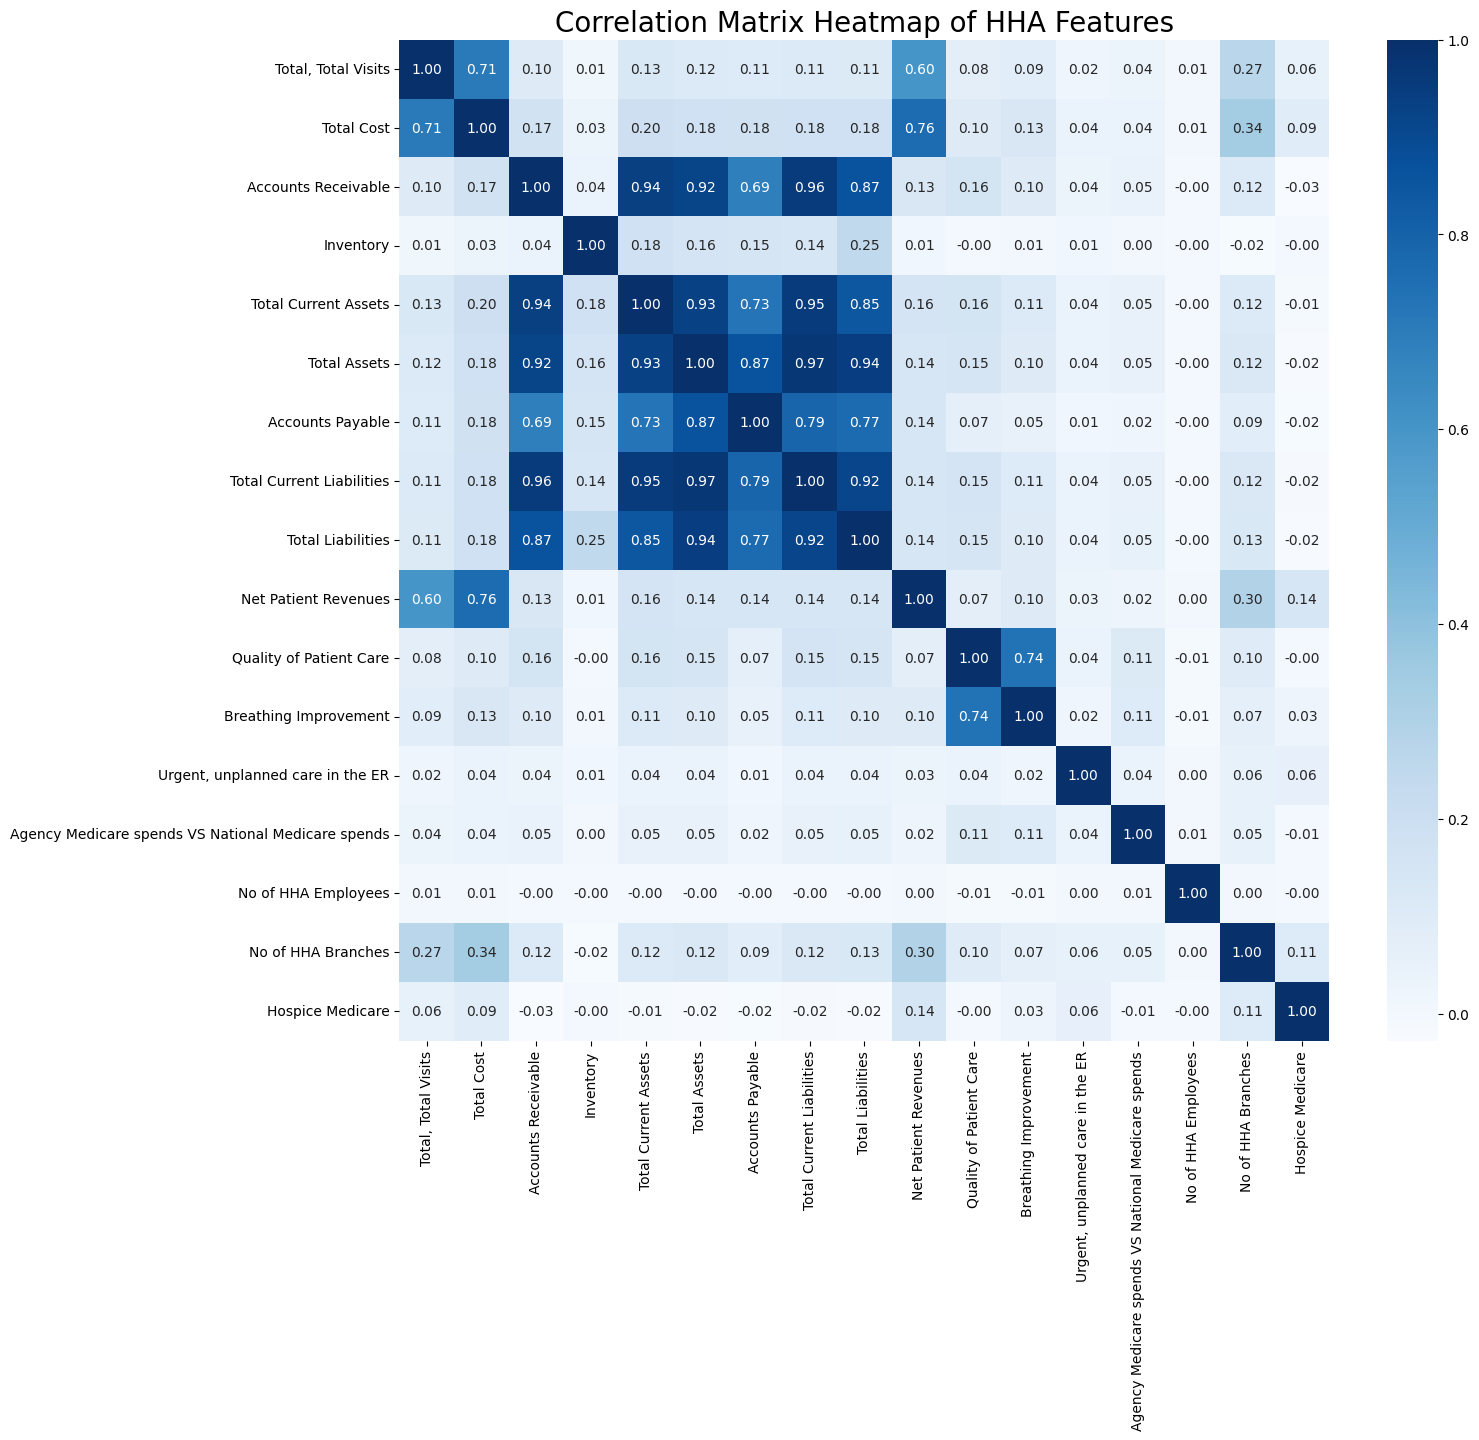

In [12]:
final_df_corr = pd.DataFrame.corr(final_df.drop(columns=['Provider CCN','HHA Name','State Code','Net Income or Loss']).select_dtypes('number').dropna(axis = 0, how='all'))
plt.figure(figsize = (15,13))
sn.heatmap(final_df_corr, annot=True, fmt='.2f', cmap = 'Blues').set_title("Correlation Matrix Heatmap of HHA Features", fontsize = 20)
plt.show()

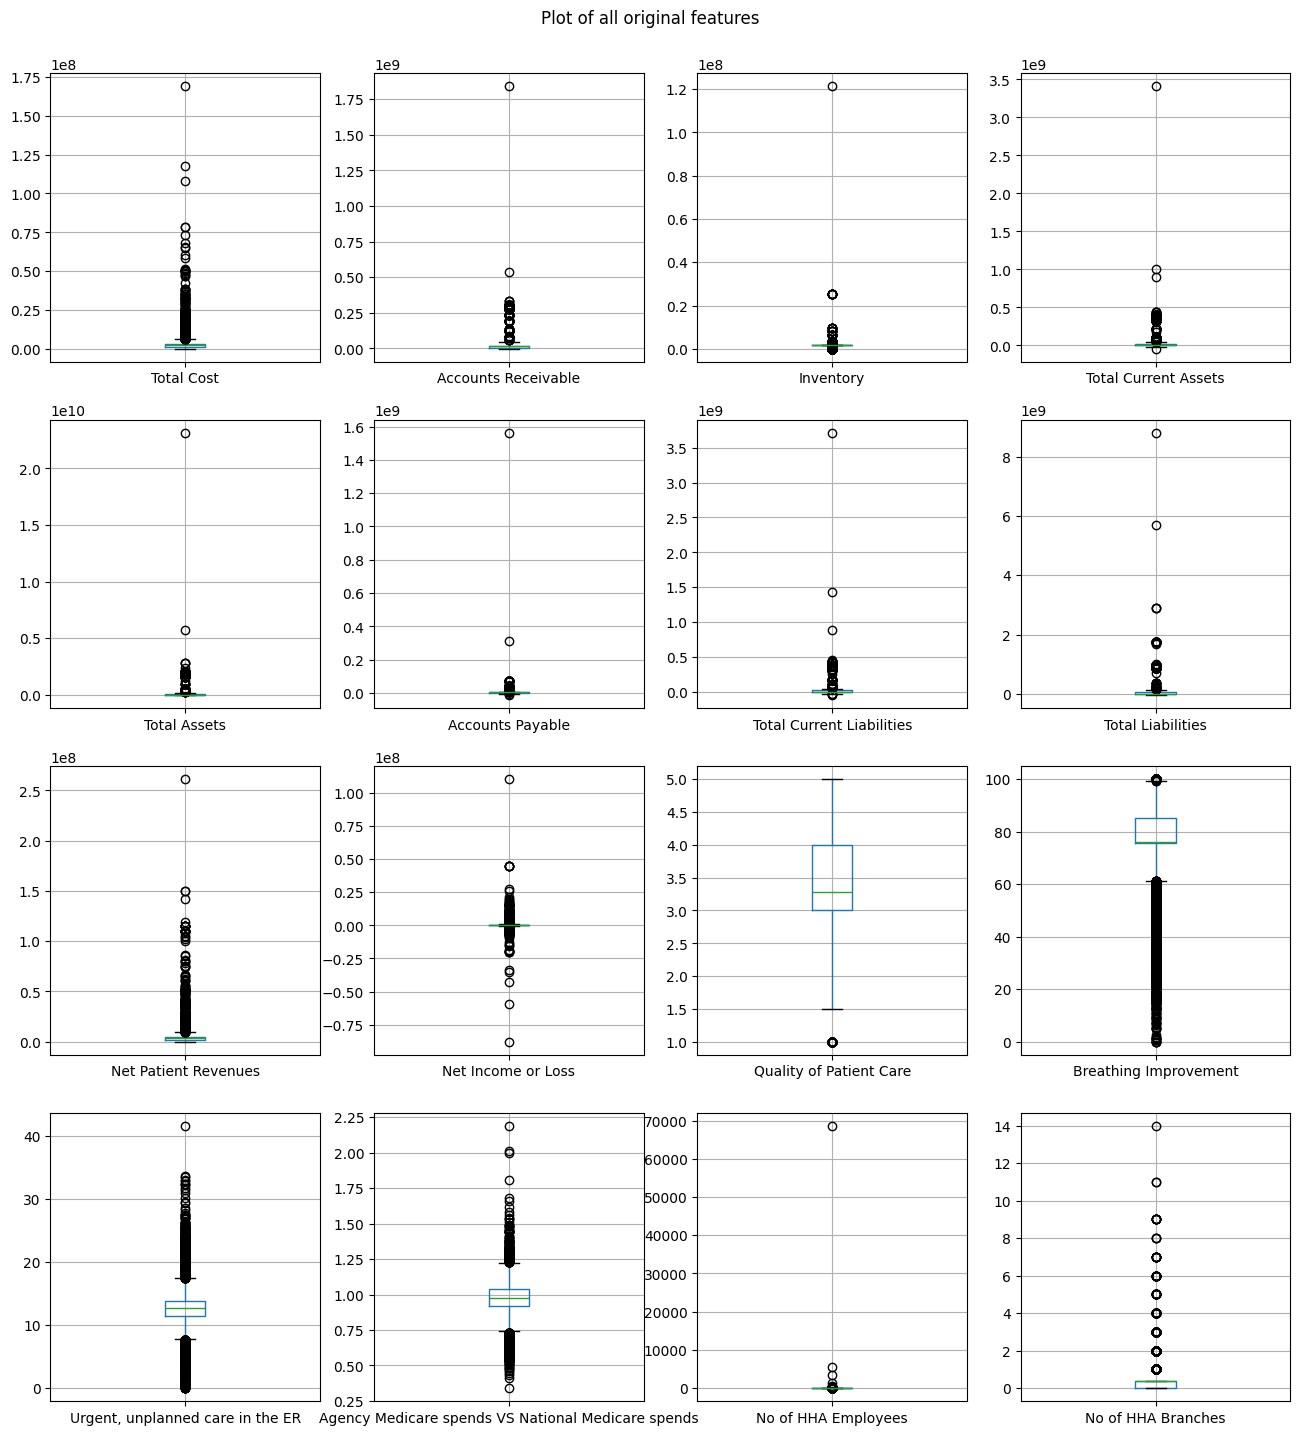

In [13]:
y_labels = final_df.select_dtypes('number').columns[1:-1]

# calculate figure size
ncols = 4
nrows = math.ceil(len(y_labels) / 4)
figsize = (ncols * 4, nrows * 4)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
fig.suptitle('Plot of all original features')
fig.subplots_adjust(top = 0.94)

# set y_labels index
y_idx = 0

# drawing plots
for axs in axes:
    for ax in axs:
        final_df.boxplot(column = y_labels[y_idx], ax = ax)
        y_idx += 1

In [14]:
# Calculate current and debt ratios
final_df['Current Ratio'] = final_df['Total Current Assets']/final_df['Total Current Liabilities']
final_df['Debt Ratio'] = final_df['Total Liabilities']/final_df['Total Assets']

# Import 2020 Cost report data with relevant fields
fields = ['Provider CCN','Accounts Receivable', 'Inventory','Accounts Payable','Net Patient Revenues (line 1 minus line 2) Total']
HHA_costreport_2020 = pd.read_csv(r"HHA_Cost_Report_2020.csv", index_col=None, skipinitialspace=True, usecols=fields)
HHA_costreport_2020.rename({'Accounts Receivable':'Accounts Receivable_20','Inventory':'Inventory_20','Accounts Payable':'Accounts Payable_20','Net Patient Revenues (line 1 minus line 2) Total':'Net Patient Revenues_20'}, axis = 'columns', inplace = True)
HHA_costreport_2020['Provider CCN'] = HHA_costreport_2020['Provider CCN'].astype(str)
HHA_costreport_2020.head()

,Provider CCN,Accounts Receivable_20,Inventory_20,Accounts Payable_20,Net Patient Revenues_20
0,67536,NaN,NaN,NaN,NaN
1,398064,NaN,NaN,NaN,NaN
2,398111,NaN,NaN,NaN,NaN
3,398235,NaN,NaN,NaN,NaN
4,397630,NaN,NaN,NaN,NaN


In [15]:
final_df = final_df.merge(HHA_costreport_2020, left_on = 'Provider CCN', right_on = 'Provider CCN', how = 'left')
# Calculate turnover ratios and cash conversion cycle
final_df['Cash Conversion Cycle'] = ((final_df['Accounts Receivable'] + final_df['Accounts Receivable_20']/2)/final_df['Net Patient Revenues'])*365 + ((final_df['Inventory'] + final_df['Inventory_20']/2)/final_df['Total Cost'])*365 + ((final_df['Accounts Payable'] + final_df['Accounts Payable_20']/2)/final_df['Total Cost'])*365
final_df = final_df.loc[:,['Provider CCN', 'HHA Name', 'State Code', 'Total, Total Visits', 'Total Cost', 'Net Income or Loss', 'Type of Ownership', 'Quality of Patient Care',
       'Breathing Improvement', 'Urgent, unplanned care in the ER',
       'Agency Medicare spends VS National Medicare spends','No of HHA Employees', 'No of HHA Branches', 'Hospice Medicare', 'Medicare/Medicaid/Both', 'Current Ratio', 'Debt Ratio', 'Cash Conversion Cycle']]
final_df['Cash Conversion Cycle'] = imputer.fit_transform(final_df[['Cash Conversion Cycle']])

In [16]:
final_df2 = final_df[(final_df['Current Ratio'] > 0) & (final_df['Current Ratio'] <= 20)]
final_df2['Net_Loss/Net_Income (0,1)'] = final_df2.apply(lambda row: 1 if row['Net Income or Loss'] >= 1 else 0, axis = 1)
final_df2.drop(columns= ['Net Income or Loss','Provider CCN','HHA Name','State Code'], inplace = True)
final_df2.head()

,"Total, Total Visits",Total Cost,Type of Ownership,Quality of Patient Care,Breathing Improvement,"Urgent, unplanned care in the ER",Agency Medicare spends VS National Medicare spends,No of HHA Employees,No of HHA Branches,Hospice Medicare,Medicare/Medicaid/Both,Current Ratio,Debt Ratio,Cash Conversion Cycle,"Net_Loss/Net_Income (0,1)"
0,31663.00,5814627.00,VOLUNTARY NON PROFIT - RELIGIOUS AFFILIATION,3.00,92.40,15.60,0.91,15.87,0.37,0.00,medicare-18 medicaid-19,1.90,-1.07,3301.96,1
1,4725.00,730909.00,VOLUNTARY NON PROFIT - RELIGIOUS AFFILIATION,3.00,59.50,7.50,1.05,15.87,0.37,0.00,medicare-18 medicaid-19,7.41,0.14,3301.96,0
2,22750.46,3071628.05,PROPRIETARY,3.29,76.20,12.69,0.97,1.00,0.00,0.00,medicare-18 medicaid-19,1.00,0.58,3301.96,1
3,22750.46,3071628.05,PROPRIETARY,3.29,76.20,12.69,0.97,27.00,0.37,0.00,medicare-18 medicaid-19,1.00,0.58,3301.96,1
7,16008.00,2297723.00,PROPRIETARY,3.00,73.60,13.30,1.13,15.87,1.00,1.00,medicare-18 medicaid-19,7.38,0.95,3301.96,0


In [17]:
final_df2['Net_Loss/Net_Income (0,1)'].value_counts(normalize= True) * 100

Net_Loss/Net_Income (0,1)
1   76.29
0   23.71
Name: proportion, dtype: float64

In [18]:
#  Regression Frame for targeting
targeting_index = final_df2[final_df2['Net_Loss/Net_Income (0,1)'] == 0].index

# Label Encode Categorical Features
#Create a label encoder object
le = LabelEncoder()
# Encode for all categorical features
le_count = 0
for col in final_df2.columns[:-1]: # -1 because the last column in this example is the target variable
    if final_df2[col].dtype == 'object':
        le.fit(final_df2[col])
        final_df2[col] = le.transform(final_df2[col])
        le_count += 1
print('{} columns were label encoded.'.format(le_count))


2 columns were label encoded.


In [19]:
# Prepare for X and y
X = final_df2.iloc[:,0:14]
y = final_df2.loc[:,'Net_Loss/Net_Income (0,1)']

In [20]:
# randomly split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state= 200) # here we use 70% test data; feel free to change
final_df3 = X_test.copy()

## Regression Models

### Lasso, Elastic Net, Ridge Regressions (Value of Incentivizing)

In [21]:
# obtain test and train data
regression_X_test = final_df2.loc[X_test.index].drop(columns = 'Quality of Patient Care')
regression_X_test = regression_X_test[regression_X_test.index.isin(list(targeting_index))]
regression_X_train = final_df2.loc[X_train.index].drop(columns = 'Quality of Patient Care')
regression_X_train = regression_X_train[regression_X_train.index.isin(list(targeting_index))]
regression_y_test = final_df2.loc[y_test.index,'Quality of Patient Care']
regression_y_test = regression_y_test[regression_y_test.index.isin(list(targeting_index))]
regression_y_train = final_df2.loc[y_train.index,'Quality of Patient Care']
regression_y_train = regression_y_train[regression_y_train.index.isin(list(targeting_index))]

In [22]:
# Linear Regression
linmodel = LinearRegression()
negMSE = cross_val_score(linmodel,regression_X_train, regression_y_train, scoring = 'neg_mean_squared_error', cv = 10)
mean_negMSE = np.mean(negMSE)
print("Linear Regression Negative Mean squared Error: ", '{:.4}'.format(mean_negMSE))

param_grid = {'alpha': np.arange(0.001, 100, 0.1)}

# Lasso Regression
lassoRegressor = GridSearchCV(Lasso(), param_grid, scoring = 'neg_mean_squared_error', verbose = 0, cv = 10)
lassoRegressor.fit(regression_X_train,regression_y_train) # fitting the model for grid search
print("Lasso Regression best alpha : ", '{:.4}'.format(lassoRegressor.best_params_.get('alpha')))
print("Lasso Regression cost function score : ", '{:.4}'.format(lassoRegressor.best_score_))

# Ridge Regression
ridgeRegressor = GridSearchCV(Ridge(), param_grid, scoring = 'neg_mean_squared_error', verbose = 0, cv = 10)
ridgeRegressor.fit(regression_X_train,regression_y_train)  # fitting the model for grid search
print("Ridge Regression best alpha : ", '{:.4}'.format(ridgeRegressor.best_params_.get('alpha')))
print("Ridge Regression cost function score : ", '{:.4}'.format(ridgeRegressor.best_score_))

# ElasticNet Regression
elasticnetRegressor = GridSearchCV(ElasticNet(), param_grid, scoring = 'neg_mean_squared_error', verbose = 0, cv = 10)
elasticnetRegressor.fit(regression_X_train,regression_y_train)  # fitting the model for grid search
print("ElasticNet Regression best alpha : ", '{:.4}'.format(elasticnetRegressor.best_params_.get('alpha')))
print("ElasticNet Regression cost function score : ", '{:.4}'.format(elasticnetRegressor.best_score_))

Linear Regression Negative Mean squared Error:  -0.3861
Lasso Regression best alpha :  0.001
Lasso Regression cost function score :  -0.3859
Ridge Regression best alpha :  99.9
Ridge Regression cost function score :  -0.3851
ElasticNet Regression best alpha :  0.001
ElasticNet Regression cost function score :  -0.386


In [26]:
# Initialize a list to store the models and their corresponding names
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": GridSearchCV(Lasso(), param_grid={'alpha': np.arange(0.001, 100, 0.1)},
                                     scoring='neg_mean_squared_error', cv=10),
    "Ridge Regression": GridSearchCV(Ridge(), param_grid={'alpha': np.arange(0.001, 100, 0.1)},
                                     scoring='neg_mean_squared_error', cv=10),
    "ElasticNet Regression": GridSearchCV(ElasticNet(), param_grid={'alpha': np.arange(0.001, 100, 0.1)},
                                           scoring='neg_mean_squared_error', cv=10)
}

# Create an empty list to store the metrics
metrics_data = []

# Iterate over each model and collect metrics
for model_name, model in models.items():
    if isinstance(model, GridSearchCV):  # For models with hyperparameters tuning
        model.fit(regression_X_train, regression_y_train)
        train_mse = -model.best_score_
        parameters = "None"  # Placeholder for parameters in models with hyperparameters tuning
        hyperparameters = model.best_params_.get('alpha')
    else:  # For models without hyperparameters tuning
        negMSE = cross_val_score(model, regression_X_train, regression_y_train, scoring='neg_mean_squared_error', cv=10)
        train_mse = np.mean(negMSE)
        parameters = "None"  # Placeholder for parameters in models without hyperparameters tuning
        hyperparameters = "None"  # Placeholder for hyperparameters in models without hyperparameters tuning

    # Placeholder for test MSE, AUC, and Precision
    test_mse = "Not calculated"
    auc = "Not calculated"
    precision = "Not calculated"

    # Append metrics to the list
    metrics_data.append([model_name, train_mse, test_mse, parameters, hyperparameters, auc, precision])

# Create DataFrame from the list of metrics
metrics_df = pd.DataFrame(metrics_data, columns=['Model', 'Train MSE', 'Test MSE', 'Parameters', 'Hyperparameters', 'AUC', 'Precision'])

# Print the metrics DataFrame
metrics_df


,Model,Train MSE,Test MSE,Parameters,Hyperparameters,AUC,Precision
0,Linear Regression,-0.39,Not calculated,None,None,Not calculated,Not calculated
1,Lasso Regression,0.39,Not calculated,None,0.00,Not calculated,Not calculated
2,Ridge Regression,0.39,Not calculated,None,99.90,Not calculated,Not calculated
3,ElasticNet Regression,0.39,Not calculated,None,0.00,Not calculated,Not calculated


In [27]:
from sklearn.metrics import mean_squared_error

# Lasso model
lasso_params = lassoRegressor.best_params_
lasso_train_mse = mean_squared_error(regression_y_train, lassoRegressor.predict(regression_X_train))
lasso_test_mse = mean_squared_error(regression_y_test, lassoRegressor.predict(regression_X_test))

# Ridge model
ridge_params = ridgeRegressor.best_params_
ridge_train_mse = mean_squared_error(regression_y_train, ridgeRegressor.predict(regression_X_train))
ridge_test_mse = mean_squared_error(regression_y_test, ridgeRegressor.predict(regression_X_test))

# ElasticNet model
elasticnet_params = elasticnetRegressor.best_params_
elasticnet_train_mse = mean_squared_error(regression_y_train, elasticnetRegressor.predict(regression_X_train))
elasticnet_test_mse = mean_squared_error(regression_y_test, elasticnetRegressor.predict(regression_X_test))

# Print results for Lasso
print("Lasso:")
print("Best parameters:", lasso_params)
print("Train MSE:", lasso_train_mse)
print("Test MSE:", lasso_test_mse)

# Print results for Ridge
print("\nRidge:")
print("Best parameters:", ridge_params)
print("Train MSE:", ridge_train_mse)
print("Test MSE:", ridge_test_mse)

# Print results for ElasticNet
print("\nElasticNet:")
print("Best parameters:", elasticnet_params)
print("Train MSE:", elasticnet_train_mse)
print("Test MSE:", elasticnet_test_mse)

Lasso:
Best parameters: {'alpha': 0.001}
Train MSE: 0.375700397083986
Test MSE: 1.2592193575572266

Ridge:
Best parameters: {'alpha': 99.90100000000001}
Train MSE: 0.3760184331860468
Test MSE: 1.408624590780083

ElasticNet:
Best parameters: {'alpha': 0.001}
Train MSE: 0.3756470755748348
Test MSE: 1.2483680245979774


##### There isn't a huge difference between the scores for Lasso and Ridge, and their cost function scores are both pretty close to the linear regression model's negative mean squared error..

#### Quality of Service (Vi(x)) Lasso, Ridge, and ElasticNet predictions

In [28]:
# Define a custom function to check if the row index exists
def assign_value(idx):
    if idx in df.index:
        return df.loc[idx, 'QOS']
    else:
        return 0

# Vi(x) Lasso Predictions
df = pd.DataFrame(lassoRegressor.predict(regression_X_test), index=regression_X_test.index, columns = ['QOS'])
# Apply the function to create a new column based on the desired condition
final_df3['LASSO Quality of Service'] = final_df3.index.map(assign_value)

# Vi(x) Ridge Predictions
df = pd.DataFrame(ridgeRegressor.predict(regression_X_test), index=regression_X_test.index, columns = ['QOS'])
final_df3['RIDGE Quality of Service'] = final_df3.index.map(assign_value)

# Vi(x) ElasticNet Predictions
df = pd.DataFrame(ridgeRegressor.predict(regression_X_test), index=regression_X_test.index, columns = ['QOS'])
final_df3['ELASTICNET Quality of Service'] =  final_df3.index.map(assign_value)

final_df3

,"Total, Total Visits",Total Cost,Type of Ownership,Quality of Patient Care,Breathing Improvement,"Urgent, unplanned care in the ER",Agency Medicare spends VS National Medicare spends,No of HHA Employees,No of HHA Branches,Hospice Medicare,Medicare/Medicaid/Both,Current Ratio,Debt Ratio,Cash Conversion Cycle,LASSO Quality of Service,RIDGE Quality of Service,ELASTICNET Quality of Service
6116,113294.00,15463511.00,3,4.50,90.80,13.90,1.03,2.00,0.37,0.00,2,0.95,0.48,3301.96,0.00,0.00,0.00
8714,64711.00,9552454.00,0,4.50,91.60,15.10,0.93,7.00,0.00,0.00,3,0.65,1.36,3301.96,0.00,0.00,0.00
6309,22750.46,3071628.05,5,3.29,76.20,12.69,0.97,0.00,0.37,0.00,3,1.00,0.58,3301.96,0.00,0.00,0.00
2203,22750.46,3071628.05,3,3.29,76.20,12.69,0.97,15.87,0.37,0.00,3,1.00,0.58,3301.96,0.00,0.00,0.00
9652,1341.00,806301.00,3,2.00,65.00,14.90,0.94,0.50,0.37,0.00,2,2.70,0.63,3301.96,2.95,2.93,2.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5010,11343.00,1639739.00,3,4.00,90.60,13.60,1.05,0.10,0.00,0.00,3,1.19,3.46,3301.96,3.83,3.84,3.84
3876,2969.00,591428.00,3,2.50,75.50,12.69,0.73,1.00,0.00,0.00,2,6.79,1.51,3301.96,0.00,0.00,0.00
2785,22750.46,3071628.05,3,3.29,76.20,12.69,0.97,0.25,1.00,0.00,3,1.00,0.58,3301.96,0.00,0.00,0.00
1368,22750.46,3071628.05,3,3.29,76.20,12.69,0.97,0.00,0.00,0.00,3,1.00,0.58,3301.96,0.00,0.00,0.00


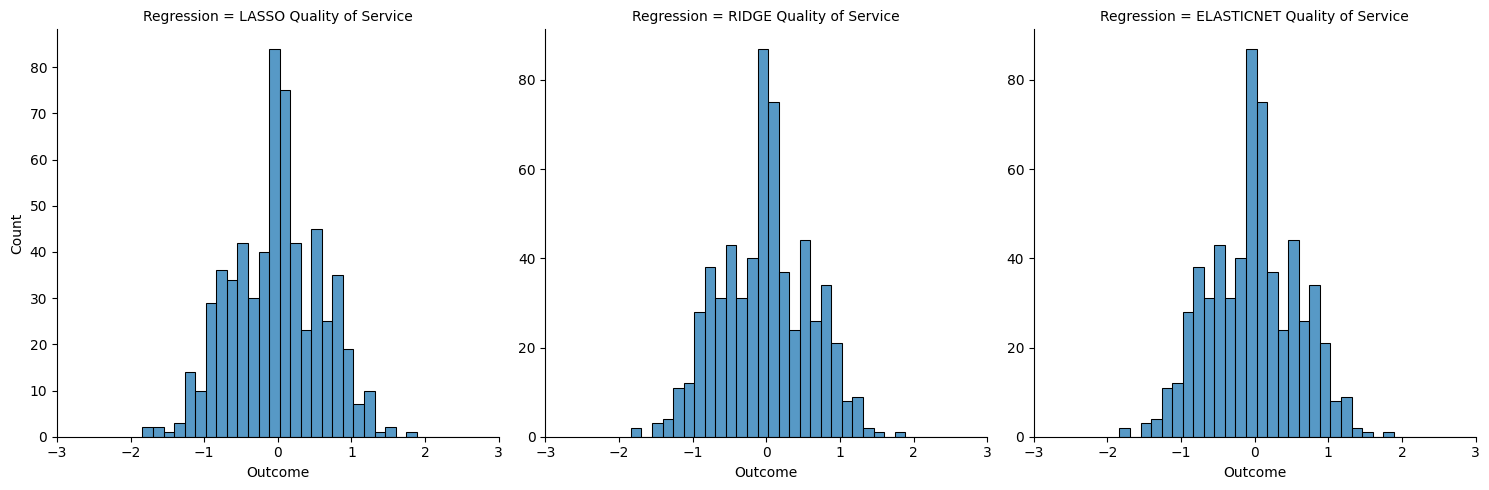

In [29]:
plotframe = final_df3.loc[final_df3.index.isin(list(targeting_index)),['LASSO Quality of Service', 'RIDGE Quality of Service', 'ELASTICNET Quality of Service' ]]
plotframe['Y_test'] = regression_y_test
plotframe = plotframe.sub(plotframe['Y_test'], axis = 0) * -1
plotframe = plotframe.drop(columns = 'Y_test').melt(var_name = 'Regression')
plotframe.rename({'value':'Outcome'}, axis = 'columns', inplace = True)
g = sn.displot(data=plotframe, col='Regression', col_wrap=3, x='Outcome',  fill=True, facet_kws={'sharey': False, 'sharex': False,  'xlim': (-3,3)})

#### Plots showing the probability distribution function for the difference the actual dependent features and the predicted dependent feature through the regressors.

## Classification Trees

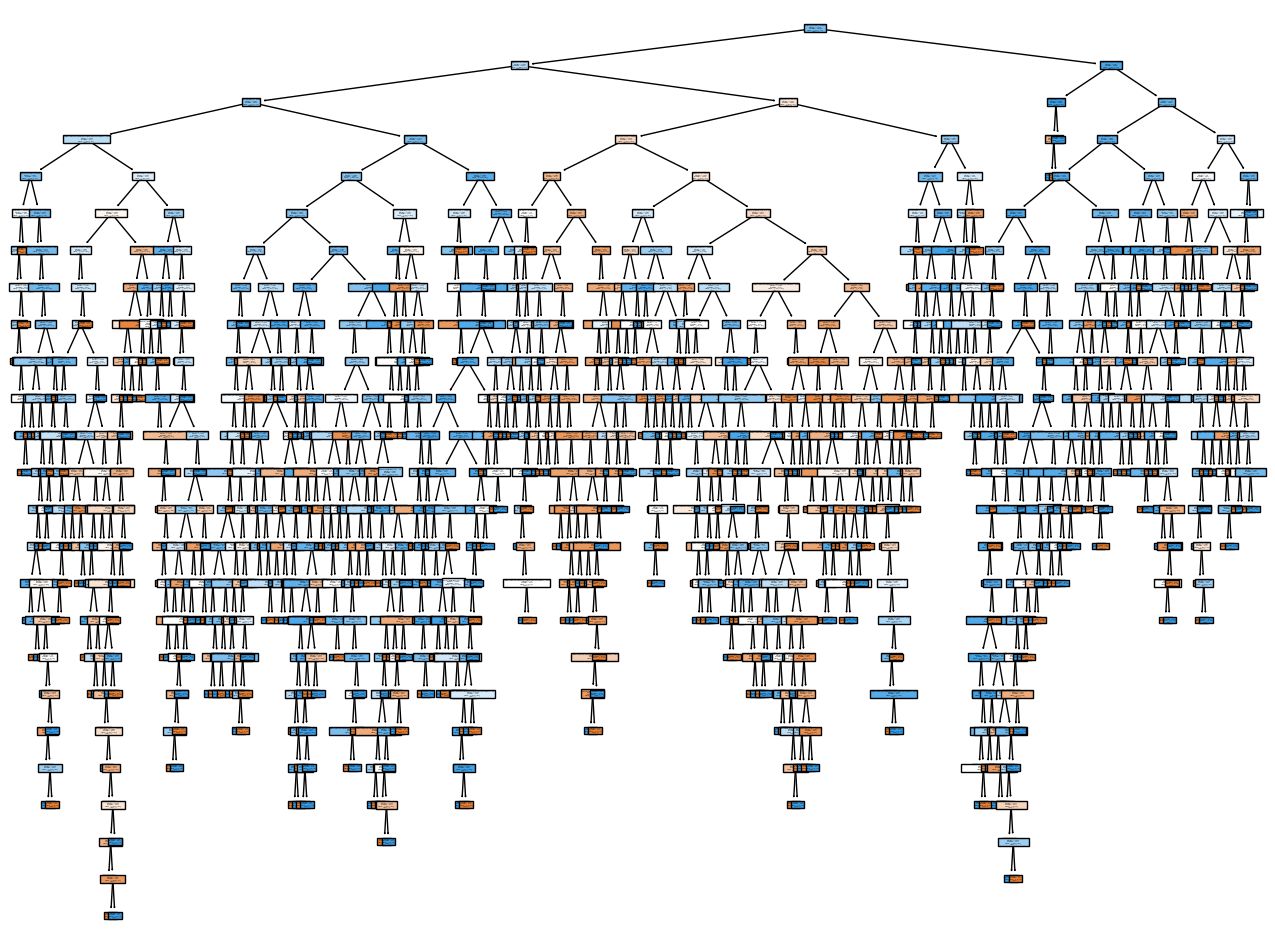

In [30]:
# fit classification tree
dtc = DecisionTreeClassifier(criterion='entropy') # default setting: criterion='gini'
dtc_model=dtc.fit(X_train,y_train)

# Visualize classification tree
fn = list(X_train.columns) # specify feature names
cn = [str(i) for i in dtc_model.classes_ ] # specify class names
plt.figure(figsize = (16,12))
plot_tree(dtc_model, feature_names = fn, class_names = cn, filled = True, proportion=True); # set "proportion=True" to see the values of class probability


#### Tree Pruning & Classification Trees Prediction
- Control model complexity to deal with overfitting
    - max_depth: The maximum depth of the tree.
    - min_samples_leaf: The minimum number of samples required to be at a leaf node.
- Regularization
    - ccp_alpha: Complexity parameter used for Minimal Cost-Complexity Pruning. That is, the penalty on the # of leaf nodes.

GridSearchCV to tune multiple Hyperparameters

In [36]:
# define parameter range
param_grid = {'max_depth': np.arange(1,10,1),
              'min_samples_leaf': np.arange(2,20,2),
              'ccp_alpha': np.arange(0,1,0.05)}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit = True, verbose = 0, n_jobs = -1)

# fitting the model for grid search
grid.fit(X_train,y_train)

# print best parameter after tuning
print("Decision Tree Classifier:")
print("Best parameters:", grid.best_params_)
grid_predictions = grid.predict(X_test)

# print classification report
print(classification_report(y_test, grid_predictions))


Decision Tree Classifier:
Best parameters: {'ccp_alpha': 0.0, 'max_depth': 4, 'min_samples_leaf': 2}
              precision    recall  f1-score   support

           0       0.59      0.45      0.51       613
           1       0.84      0.90      0.87      1948

    accuracy                           0.79      2561
   macro avg       0.71      0.68      0.69      2561
weighted avg       0.78      0.79      0.78      2561



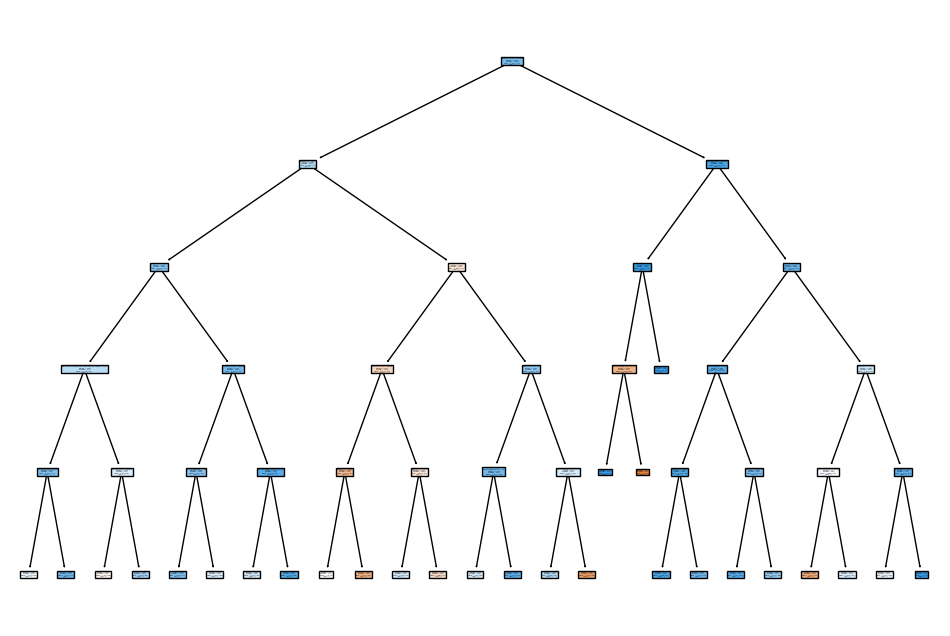

In [37]:
#   plot of classification trees using tuned hyperparameters from GridSearchCV
# fit classification tree
dtc = DecisionTreeClassifier(ccp_alpha=0.0, min_samples_leaf=2, max_depth=5, criterion='entropy') # default setting: criterion='gini'
dtc_model=dtc.fit(X_train,y_train)

# Visualize classification tree
fn = list(X_train.columns) # specify feature names
cn = [str(i) for i in dtc_model.classes_ ] # specify class names
plt.figure(figsize = (12,8))
plot_tree(dtc_model, feature_names = fn, class_names = cn, filled = True, proportion=True); # set "proportion=True" to see the values of class probability

#### Class Predictions

In [38]:
final_df3['DECISION TREE NetIncome/Loss Probability'] = [i[0] for i in dtc_model.predict_proba(X_test)]
final_df3.head()

,"Total, Total Visits",Total Cost,Type of Ownership,Quality of Patient Care,Breathing Improvement,"Urgent, unplanned care in the ER",Agency Medicare spends VS National Medicare spends,No of HHA Employees,No of HHA Branches,Hospice Medicare,Medicare/Medicaid/Both,Current Ratio,Debt Ratio,Cash Conversion Cycle,LASSO Quality of Service,RIDGE Quality of Service,ELASTICNET Quality of Service,DECISION TREE NetIncome/Loss Probability
6116,113294.00,15463511.00,3,4.50,90.80,13.90,1.03,2.00,0.37,0.00,2,0.95,0.48,3301.96,0.00,0.00,0.00,0.08
8714,64711.00,9552454.00,0,4.50,91.60,15.10,0.93,7.00,0.00,0.00,3,0.65,1.36,3301.96,0.00,0.00,0.00,0.45
6309,22750.46,3071628.05,5,3.29,76.20,12.69,0.97,0.00,0.37,0.00,3,1.00,0.58,3301.96,0.00,0.00,0.00,0.00
2203,22750.46,3071628.05,3,3.29,76.20,12.69,0.97,15.87,0.37,0.00,3,1.00,0.58,3301.96,0.00,0.00,0.00,0.00
9652,1341.00,806301.00,3,2.00,65.00,14.90,0.94,0.50,0.37,0.00,2,2.70,0.63,3301.96,2.95,2.93,2.93,0.26


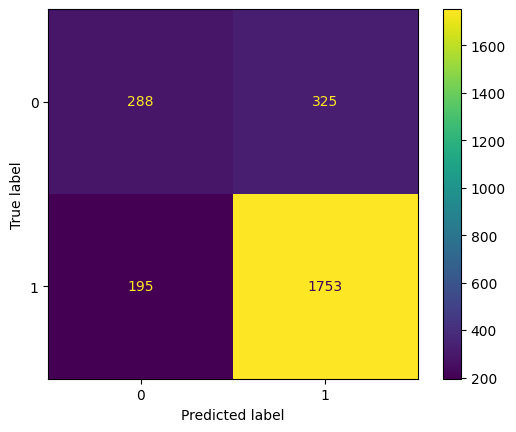

In [39]:
# Visualize the confusion matrix

# Evaluate using the test data
y_pred = dtc_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=dtc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dtc.classes_)
disp.plot()
plt.show()

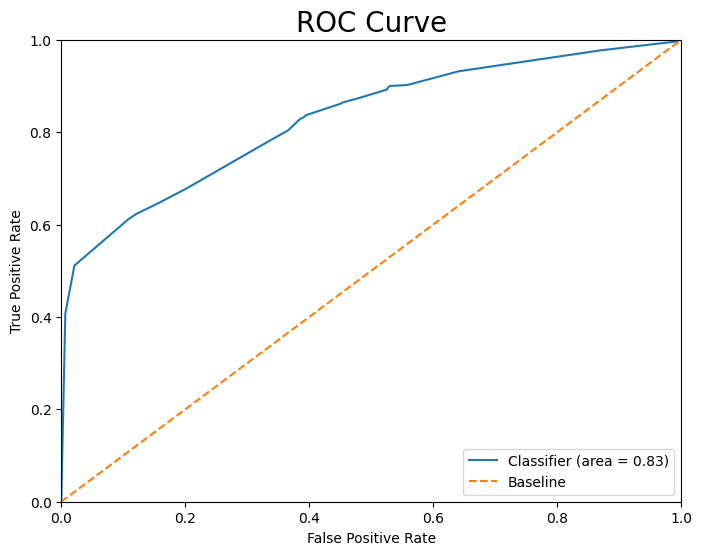

In [40]:
# Encoding target variables for ROC Curve Plot
# 0: LEAVE; 1: STAY
le.fit(y_test)
y_test_DTC = le.transform(y_test)
le.fit(y_train)
y_train_DTC = le.transform(y_train)

# Calculate class probabilities, generate ROC curve, and compute AUC
y_proba=dtc_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_DTC, y_proba)
classifier_roc_auc = roc_auc_score(y_test_DTC, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Classifier (area = %0.2f)' % classifier_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Baseline', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve',fontsize = "20")
plt.legend(loc="lower right")
plt.show()

## Logistic Regression

In [43]:
# Define parameter range for Logistic Regression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

# Initialize GridSearchCV for Logistic Regression
log_reg_grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, refit=True, verbose=0, n_jobs=-1)

# Fit the model for grid search
log_reg_grid.fit(X_train, y_train)

# Print best parameters after tuning
print("Logistic Regression:")
print("Best parameters:", log_reg_grid.best_params_)

# Make predictions using the best estimator
log_reg_predictions = log_reg_grid.predict(X_test)

# Print classification report
print(classification_report(y_test, log_reg_predictions))

# fit regression model with hyperparameters
logisticRegmodel = LogisticRegression(random_state=0, solver='liblinear' , C = 0.001, penalty= 'l1').fit(X_train, y_train)

# print coefficients and the intercept
print('The intercept beta_0 of the logistic regression model is ', logisticRegmodel.intercept_, '\n')

pd.set_option('display.float_format', lambda x: '%.7f' % x)
styles = [dict(selector = 'caption', props = [('font-size', "120%"), ('font-weight', 'bold'), ('text-align','left')])]

d = {'Parameter':X_train.columns,'Coefficients':logisticRegmodel.coef_.flatten()}
HHAIncome_LogisticReg = pd.DataFrame(d)
HHAIncome_LogisticReg.style.set_caption('')

Logistic Regression:
Best parameters: {'C': 0.001, 'penalty': 'l1'}
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       613
           1       0.76      1.00      0.87      1948

    accuracy                           0.76      2561
   macro avg       0.88      0.50      0.44      2561
weighted avg       0.82      0.76      0.66      2561

The intercept beta_0 of the logistic regression model is  [0.] 



,Parameter,Coefficients
0,"Total, Total Visits",0.000039
1,Total Cost,-0.000000
2,Type of Ownership,0.000000
3,Quality of Patient Care,0.000000
4,Breathing Improvement,0.006234
5,"Urgent, unplanned care in the ER",0.000000
6,Agency Medicare spends VS National Medicare spends,0.000000
7,No of HHA Employees,0.001140
8,No of HHA Branches,0.000000
9,Hospice Medicare,0.000000


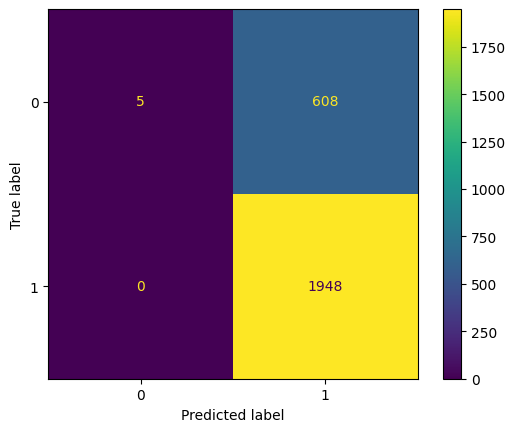

In [44]:
y_pred = logisticRegmodel.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=logisticRegmodel.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logisticRegmodel.classes_)
disp.plot()
plt.show()

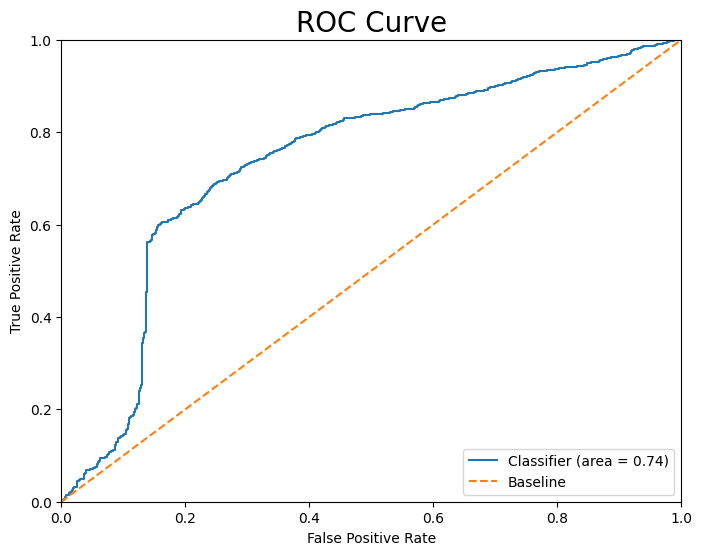

In [45]:
# Encoding target variables for ROC Curve Plot
# 0: LEAVE; 1: STAY
le.fit(y_test)
y_test_logisReg =le.transform(y_test)
le.fit(y_train)
y_train_logisReg =le.transform(y_train)

# Calculate class probabilities, generate ROC curve, and compute AUC
y_proba= logisticRegmodel.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test_logisReg, y_proba)
classifier_roc_auc = roc_auc_score(y_test_logisReg, y_proba)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Classifier (area = %0.2f)' % classifier_roc_auc)

# Plot Base Rate ROC
plt.plot([0,1], [0,1],label='Baseline', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve',fontsize = "20")
plt.legend(loc="lower right")
plt.show()

#### Class Predictions

In [46]:
final_df3['LOGISTIC REGRESSION NetIncome/Loss Probability'] = [i[0] for i in logisticRegmodel.predict_proba(X_test)]
final_df3.head()

,"Total, Total Visits",Total Cost,Type of Ownership,Quality of Patient Care,Breathing Improvement,"Urgent, unplanned care in the ER",Agency Medicare spends VS National Medicare spends,No of HHA Employees,No of HHA Branches,Hospice Medicare,Medicare/Medicaid/Both,Current Ratio,Debt Ratio,Cash Conversion Cycle,LASSO Quality of Service,RIDGE Quality of Service,ELASTICNET Quality of Service,DECISION TREE NetIncome/Loss Probability,LOGISTIC REGRESSION NetIncome/Loss Probability
6116,113294.0000000,15463511.0000000,3,4.5000000,90.8000000,13.9000000,1.0300000,2.0000000,0.3662749,0.0000000,2,0.9529828,0.4751248,3301.9612296,0.0000000,0.0000000,0.0000000,0.0843806,0.0401362
8714,64711.0000000,9552454.0000000,0,4.5000000,91.6000000,15.1000000,0.9300000,7.0000000,0.0000000,0.0000000,3,0.6510890,1.3636585,3301.9612296,0.0000000,0.0000000,0.0000000,0.4482759,0.1084846
6309,22750.4593496,3071628.0461172,5,3.2858672,76.1950065,12.6872813,0.9733781,0.0000000,0.3662749,0.0000000,3,1.0045374,0.5844451,3301.9612296,0.0000000,0.0000000,0.0000000,0.0000000,0.2209091
2203,22750.4593496,3071628.0461172,3,3.2858672,76.1950065,12.6872813,0.9733781,15.8732666,0.3662749,0.0000000,3,1.0045374,0.5844451,3301.9612296,0.0000000,0.0000000,0.0000000,0.0000000,0.2178114
9652,1341.0000000,806301.0000000,3,2.0000000,65.0000000,14.9000000,0.9400000,0.5000000,0.3662749,0.0000000,2,2.6950373,0.6280632,3301.9612296,2.9515250,2.9322618,2.9322618,0.2606310,0.3387563


## SVM Trees

GridSearchCV to tune multiple Hyperparameters

In [47]:
# define parameter range
param_grid = {'C': np.arange(2, 10, 2),
              'gamma': np.arange(0.1, 1, 0.2)}

grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 0, n_jobs = -1)

# fitting the model for grid search
grid.fit(X_train,y_train)

# print best parameter after tuning
print("SVM")
print('Best Parameters: ', grid.best_params_)
grid_predictions = grid.predict(X_test)

# print classification report
print(classification_report(y_test, grid_predictions))

SVM
Best Parameters:  {'C': 2, 'gamma': 0.1}
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       613
           1       0.76      1.00      0.86      1948

    accuracy                           0.76      2561
   macro avg       0.38      0.50      0.43      2561
weighted avg       0.58      0.76      0.66      2561



In [48]:
# fit SVM with linear kernel

# set "probability=True" for roc_auc_score
svc_model = SVC(probability=True, C = 2 , gamma = 0.1)
svc_model.fit(X_train, y_train)

final_df3['SVM NetIncome/Loss Probability'] = [i[0] for i in svc_model.predict_proba(X_test)]
final_df3.head()

,"Total, Total Visits",Total Cost,Type of Ownership,Quality of Patient Care,Breathing Improvement,"Urgent, unplanned care in the ER",Agency Medicare spends VS National Medicare spends,No of HHA Employees,No of HHA Branches,Hospice Medicare,Medicare/Medicaid/Both,Current Ratio,Debt Ratio,Cash Conversion Cycle,LASSO Quality of Service,RIDGE Quality of Service,ELASTICNET Quality of Service,DECISION TREE NetIncome/Loss Probability,LOGISTIC REGRESSION NetIncome/Loss Probability,SVM NetIncome/Loss Probability
6116,113294.0000000,15463511.0000000,3,4.5000000,90.8000000,13.9000000,1.0300000,2.0000000,0.3662749,0.0000000,2,0.9529828,0.4751248,3301.9612296,0.0000000,0.0000000,0.0000000,0.0843806,0.0401362,0.3318722
8714,64711.0000000,9552454.0000000,0,4.5000000,91.6000000,15.1000000,0.9300000,7.0000000,0.0000000,0.0000000,3,0.6510890,1.3636585,3301.9612296,0.0000000,0.0000000,0.0000000,0.4482759,0.1084846,0.3318722
6309,22750.4593496,3071628.0461172,5,3.2858672,76.1950065,12.6872813,0.9733781,0.0000000,0.3662749,0.0000000,3,1.0045374,0.5844451,3301.9612296,0.0000000,0.0000000,0.0000000,0.0000000,0.2209091,0.0000013
2203,22750.4593496,3071628.0461172,3,3.2858672,76.1950065,12.6872813,0.9733781,15.8732666,0.3662749,0.0000000,3,1.0045374,0.5844451,3301.9612296,0.0000000,0.0000000,0.0000000,0.0000000,0.2178114,0.0000039
9652,1341.0000000,806301.0000000,3,2.0000000,65.0000000,14.9000000,0.9400000,0.5000000,0.3662749,0.0000000,2,2.6950373,0.6280632,3301.9612296,2.9515250,2.9322618,2.9322618,0.2606310,0.3387563,0.3318722


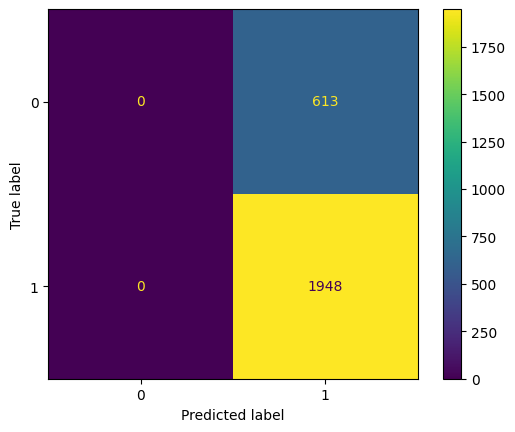

In [49]:
# Visualize the confusion matrix

# Evaluate using the test data
y_pred = svc_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=svc_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc_model.classes_)
disp.plot()
plt.show()

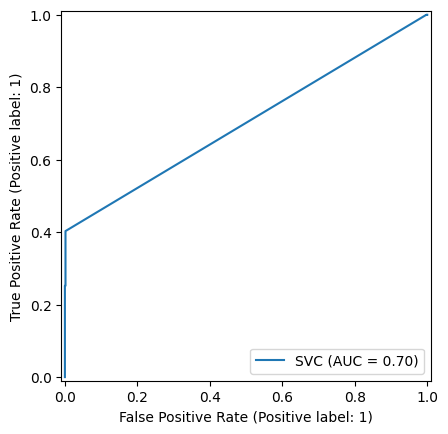

In [50]:
# ROC Curve for SVC
from sklearn.metrics import RocCurveDisplay

svc_disp = RocCurveDisplay.from_estimator(svc_model, X_test, y_test)
plt.show()

#### Total Visits (VNi(x))

In [51]:
final_df2['Pr(TotalVisit < MedianVisits)'] = final_df2.apply(lambda row: 1 if row['Total, Total Visits'] >= final_df2.loc[:,'Total, Total Visits'].mean()  else 0, axis = 1)
final_df2.head()

,"Total, Total Visits",Total Cost,Type of Ownership,Quality of Patient Care,Breathing Improvement,"Urgent, unplanned care in the ER",Agency Medicare spends VS National Medicare spends,No of HHA Employees,No of HHA Branches,Hospice Medicare,Medicare/Medicaid/Both,Current Ratio,Debt Ratio,Cash Conversion Cycle,"Net_Loss/Net_Income (0,1)",Pr(TotalVisit < MedianVisits)
0,31663.0000000,5814627.0000000,4,3.0000000,92.4000000,15.6000000,0.9100000,15.8732666,0.3662749,0.0000000,3,1.9043585,-1.0702790,3301.9612296,1,1
1,4725.0000000,730909.0000000,4,3.0000000,59.5000000,7.5000000,1.0500000,15.8732666,0.3662749,0.0000000,3,7.4073803,0.1350005,3301.9612296,0,0
2,22750.4593496,3071628.0461172,3,3.2858672,76.1950065,12.6872813,0.9733781,1.0000000,0.0000000,0.0000000,3,1.0045374,0.5844451,3301.9612296,1,0
3,22750.4593496,3071628.0461172,3,3.2858672,76.1950065,12.6872813,0.9733781,27.0000000,0.3662749,0.0000000,3,1.0045374,0.5844451,3301.9612296,1,0
7,16008.0000000,2297723.0000000,3,3.0000000,73.6000000,13.3000000,1.1300000,15.8732666,1.0000000,1.0000000,3,7.3828531,0.9478357,3301.9612296,0,0


In [52]:
# obtain test and train data
classification_X_test = final_df2.loc[X_test.index].drop(columns = ['Total, Total Visits', 'Pr(TotalVisit < MedianVisits)'])
classification_X_train = final_df2.loc[X_train.index].drop(columns = ['Total, Total Visits', 'Pr(TotalVisit < MedianVisits)'])
classification_y_test = final_df2.loc[y_test.index,'Pr(TotalVisit < MedianVisits)']
classification_y_train = final_df2.loc[y_train.index,'Pr(TotalVisit < MedianVisits)']

### Classification: Decision Trees, SVM, Logistic Regression

In [53]:
# GridSearchCV to tune multiple Hyperparameters

#  Decision Tree Classifier
# define parameter range
param_grid = {'max_depth': np.arange(1,10,1),
              'min_samples_leaf': np.arange(2,20,2),
              'ccp_alpha': np.arange(0,1,0.05)}

dtc_grid = GridSearchCV(DecisionTreeClassifier(), param_grid, refit = True, verbose = 0, n_jobs = -1)

# fitting the model for grid search
dtc_grid.fit(classification_X_train,classification_y_train)

# print best parameter after tuning
print("Descision Tree Hyperparameter Tuning\n", dtc_grid.best_params_)
dtcgrid_predictions = dtc_grid.predict(classification_X_test)

# print classification report
print(classification_report(classification_y_test, dtcgrid_predictions))

#  SVM
# define parameter range
param_grid = {'C': np.arange(2, 10, 2),
              'gamma': np.arange(0.1, 1, 0.2)}

svm_grid = GridSearchCV(SVC(probability = True), param_grid, refit = True, verbose = 0, n_jobs = -1)

# fitting the model for grid search
svm_grid.fit(classification_X_train,classification_y_train)

# print best parameter after tuning
print("\n\n", "SVM Hyperparameter Tuning\n", svm_grid.best_params_)
svmgrid_predictions = svm_grid.predict(classification_X_test)

# print classification report
print(classification_report(classification_y_test, svmgrid_predictions))


# Define parameter range for Logistic Regression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}

# Initialize GridSearchCV for Logistic Regression
logreg_grid = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, refit=True, verbose=0, n_jobs=-1)

# Fit the model for grid search
logreg_grid.fit(classification_X_train, classification_y_train)

# Make predictions using the best estimator
logreg_predictions = logreg_grid.predict(classification_X_test)

# Print classification report
print("\n\n", "Logistic Regression Hyperparameter Tuning\n",logreg_grid.best_params_)
print(classification_report(classification_y_test, logreg_predictions))

Descision Tree Hyperparameter Tuning
 {'ccp_alpha': 0.0, 'max_depth': 3, 'min_samples_leaf': 2}
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2102
           1       0.89      0.71      0.79       459

    accuracy                           0.93      2561
   macro avg       0.91      0.84      0.87      2561
weighted avg       0.93      0.93      0.93      2561



 SVM Hyperparameter Tuning
 {'C': 2, 'gamma': 0.1}
              precision    recall  f1-score   support

           0       0.82      1.00      0.90      2102
           1       0.00      0.00      0.00       459

    accuracy                           0.82      2561
   macro avg       0.41      0.50      0.45      2561
weighted avg       0.67      0.82      0.74      2561



 Logistic Regression Hyperparameter Tuning
 {'C': 100, 'penalty': 'l1'}
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2102
           1  

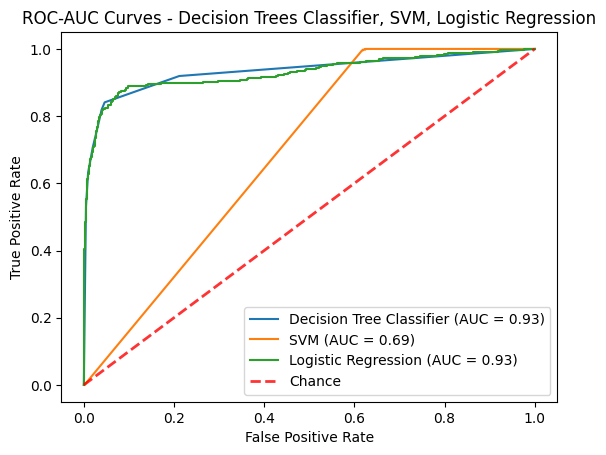

In [56]:
# Define a function to plot ROC curve and calculate AUC
def plot_roc_curve(model, X_test, y_test, model_name):
    # Get predicted probabilities
    y_pred_proba = model.predict_proba(X_test)[:,1]
    # Calculate false positive rate, true positive rate and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    # Calculate AUC
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')

# Plot ROC curve for Decision Tree Classifier
plot_roc_curve(dtc_grid, classification_X_test, classification_y_test, 'Decision Tree Classifier')

# Plot ROC curve for SVM
plot_roc_curve(svm_grid, classification_X_test, classification_y_test, 'SVM')

# Plot ROC curve for SVM
plot_roc_curve(logreg_grid, classification_X_test, classification_y_test, 'Logistic Regression')

# Show plot
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.legend(loc='lower right')
plt.title(f'ROC-AUC Curves - Decision Trees Classifier, SVM, Logistic Regression')
plt.show()


#### Class Predictions

In [57]:
final_df3['SVM Pr(tv < meantv)'] = [i[0] for i in svm_grid.predict_proba(classification_X_test)]
final_df3['DECISION TREE Pr(tv < meantv)'] = [i[0] for i in dtc_grid.predict_proba(classification_X_test)]
final_df3['Logistic Regression Pr(tv < meantv)'] = [i[0] for i in logreg_grid.predict_proba(classification_X_test)]
final_df3.head()

,"Total, Total Visits",Total Cost,Type of Ownership,Quality of Patient Care,Breathing Improvement,"Urgent, unplanned care in the ER",Agency Medicare spends VS National Medicare spends,No of HHA Employees,No of HHA Branches,Hospice Medicare,...,Cash Conversion Cycle,LASSO Quality of Service,RIDGE Quality of Service,ELASTICNET Quality of Service,DECISION TREE NetIncome/Loss Probability,LOGISTIC REGRESSION NetIncome/Loss Probability,SVM NetIncome/Loss Probability,SVM Pr(tv < meantv),DECISION TREE Pr(tv < meantv),Logistic Regression Pr(tv < meantv)
6116,113294.00,15463511.00,3,4.50,90.80,13.90,1.03,2.00,0.37,0.00,...,3301.96,0.00,0.00,0.00,0.08,0.04,0.33,0.74,0.02,0.00
8714,64711.00,9552454.00,0,4.50,91.60,15.10,0.93,7.00,0.00,0.00,...,3301.96,0.00,0.00,0.00,0.45,0.11,0.33,0.74,0.02,0.00
6309,22750.46,3071628.05,5,3.29,76.20,12.69,0.97,0.00,0.37,0.00,...,3301.96,0.00,0.00,0.00,0.00,0.22,0.00,1.00,0.98,0.90
2203,22750.46,3071628.05,3,3.29,76.20,12.69,0.97,15.87,0.37,0.00,...,3301.96,0.00,0.00,0.00,0.00,0.22,0.00,1.00,0.98,0.91
9652,1341.00,806301.00,3,2.00,65.00,14.90,0.94,0.50,0.37,0.00,...,3301.96,2.95,2.93,2.93,0.26,0.34,0.33,0.74,0.98,0.99


## Expected Value Framework

### Expected Benefit for model combinations

In [58]:
import itertools

# Define the model components for each model
model_components = {
    'NetIncome/Loss Probability': ['DECISION TREE', 'LOGISTIC REGRESSION', 'SVM'],
    'Quality of Service': ['LASSO', 'RIDGE', 'ELASTICNET'],
    'Pr(tv < meantv)': ['DECISION TREE', 'SVM', 'Logistic Regression']
}

# Generate all possible combinations of model components
all_combinations = list(itertools.product(*model_components.values()))

# Create a DataFrame to store the combinations
combinations_df = pd.DataFrame(all_combinations, columns=model_components.keys())

# Add a column to represent the model combinations
combinations_df['Model_Combinations'] = combinations_df.apply(lambda row: ' - '.join(row), axis=1)

# Display the table of all possible combinations
(combinations_df)

,NetIncome/Loss Probability,Quality of Service,Pr(tv < meantv),Model_Combinations
0,DECISION TREE,LASSO,DECISION TREE,DECISION TREE - LASSO - DECISION TREE
1,DECISION TREE,LASSO,SVM,DECISION TREE - LASSO - SVM
2,DECISION TREE,LASSO,Logistic Regression,DECISION TREE - LASSO - Logistic Regression
3,DECISION TREE,RIDGE,DECISION TREE,DECISION TREE - RIDGE - DECISION TREE
4,DECISION TREE,RIDGE,SVM,DECISION TREE - RIDGE - SVM
5,DECISION TREE,RIDGE,Logistic Regression,DECISION TREE - RIDGE - Logistic Regression
6,DECISION TREE,ELASTICNET,DECISION TREE,DECISION TREE - ELASTICNET - DECISION TREE
7,DECISION TREE,ELASTICNET,SVM,DECISION TREE - ELASTICNET - SVM
8,DECISION TREE,ELASTICNET,Logistic Regression,DECISION TREE - ELASTICNET - Logistic Regression
9,LOGISTIC REGRESSION,LASSO,DECISION TREE,LOGISTIC REGRESSION - LASSO - DECISION TREE


In [59]:
import itertools
allmodels1 = final_df3.loc[:, 'LASSO Quality of Service' : 'ELASTICNET Quality of Service' ].columns
allmodels2 = final_df3.loc[:, 'DECISION TREE NetIncome/Loss Probability' : 'SVM NetIncome/Loss Probability' ].columns
allmodels3 = final_df3.loc[:,  ['DECISION TREE Pr(tv < meantv)', 'SVM Pr(tv < meantv)', 'Logistic Regression Pr(tv < meantv)'] ].columns
allmodels = [list(tup) for tup in itertools.product(allmodels2, allmodels1, allmodels3)]
ExpectedProfit = [final_df3[algos].iloc[:,0] * final_df3[algos].iloc[:,1] + (1 - final_df3[algos].iloc[:,0]) * final_df3[algos].iloc[:,2] for algos in allmodels]
allmodelscolnames = pd.DataFrame(allmodels)
allmodelscolnames['Model_Combinations'] = allmodelscolnames[0] + ' - '  +  allmodelscolnames[1] + ' - '  + allmodelscolnames[2]
ExpectedProfit = pd.DataFrame(ExpectedProfit).T
ExpectedProfit.columns = allmodelscolnames['Model_Combinations']
ExpectedProfit['Optimal Expected Benefit Model'] = ExpectedProfit.idxmax(axis = 1)
ExpectedProfit.head()

Model_Combinations,DECISION TREE NetIncome/Loss Probability - LASSO Quality of Service - DECISION TREE Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - LASSO Quality of Service - SVM Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - LASSO Quality of Service - Logistic Regression Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - RIDGE Quality of Service - DECISION TREE Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - RIDGE Quality of Service - SVM Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - RIDGE Quality of Service - Logistic Regression Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - ELASTICNET Quality of Service - DECISION TREE Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - ELASTICNET Quality of Service - SVM Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - ELASTICNET Quality of Service - Logistic Regression Pr(tv < meantv),LOGISTIC REGRESSION NetIncome/Loss Probability - LASSO Quality of Service - DECISION TREE Pr(tv < meantv),...,SVM NetIncome/Loss Probability - LASSO Quality of Service - DECISION TREE Pr(tv < meantv),SVM NetIncome/Loss Probability - LASSO Quality of Service - SVM Pr(tv < meantv),SVM NetIncome/Loss Probability - LASSO Quality of Service - Logistic Regression Pr(tv < meantv),SVM NetIncome/Loss Probability - RIDGE Quality of Service - DECISION TREE Pr(tv < meantv),SVM NetIncome/Loss Probability - RIDGE Quality of Service - SVM Pr(tv < meantv),SVM NetIncome/Loss Probability - RIDGE Quality of Service - Logistic Regression Pr(tv < meantv),SVM NetIncome/Loss Probability - ELASTICNET Quality of Service - DECISION TREE Pr(tv < meantv),SVM NetIncome/Loss Probability - ELASTICNET Quality of Service - SVM Pr(tv < meantv),SVM NetIncome/Loss Probability - ELASTICNET Quality of Service - Logistic Regression Pr(tv < meantv),Optimal Expected Benefit Model
6116,0.02,0.68,0.00,0.02,0.68,0.00,0.02,0.68,0.00,0.02,...,0.01,0.49,0.00,0.01,0.49,0.00,0.01,0.49,0.00,LOGISTIC REGRESSION NetIncome/Loss Probability...
8714,0.01,0.41,0.00,0.01,0.41,0.00,0.01,0.41,0.00,0.02,...,0.01,0.49,0.00,0.01,0.49,0.00,0.01,0.49,0.00,LOGISTIC REGRESSION NetIncome/Loss Probability...
6309,0.98,1.00,0.90,0.98,1.00,0.90,0.98,1.00,0.90,0.76,...,0.98,1.00,0.90,0.98,1.00,0.90,0.98,1.00,0.90,DECISION TREE NetIncome/Loss Probability - LAS...
2203,0.98,1.00,0.91,0.98,1.00,0.91,0.98,1.00,0.91,0.77,...,0.98,1.00,0.91,0.98,1.00,0.91,0.98,1.00,0.91,DECISION TREE NetIncome/Loss Probability - LAS...
9652,1.49,1.31,1.50,1.49,1.31,1.50,1.49,1.31,1.50,1.65,...,1.64,1.47,1.64,1.63,1.47,1.64,1.63,1.47,1.64,LOGISTIC REGRESSION NetIncome/Loss Probability...


In [60]:
Thresh = allmodelscolnames.iloc[:,[1,2]].T; Thresh.head()
threshold = []
for i in Thresh:
    thresh = final_df3[allmodelscolnames.iloc[:,[1,2]].T.iloc[:,i].values]
    thresh = -thresh.iloc[:,1]/(thresh.iloc[:,0] - thresh.iloc[:,1])
    threshold.append(thresh)

Thresholds = pd.DataFrame(threshold).T
Thresholdnames = pd.DataFrame([list(allmodelscolnames.iloc[:,[1,2]].T.iloc[:,i].values) for i in allmodelscolnames.iloc[:,[1,2]].T])
Thresholdnames['Model_Combinations'] = Thresholdnames[0] + ' - ' + Thresholdnames[1]
Thresholds.columns = Thresholdnames['Model_Combinations']
Thresholds.head(5)

Model_Combinations,LASSO Quality of Service - DECISION TREE Pr(tv < meantv),LASSO Quality of Service - SVM Pr(tv < meantv),LASSO Quality of Service - Logistic Regression Pr(tv < meantv),RIDGE Quality of Service - DECISION TREE Pr(tv < meantv),RIDGE Quality of Service - SVM Pr(tv < meantv),RIDGE Quality of Service - Logistic Regression Pr(tv < meantv),ELASTICNET Quality of Service - DECISION TREE Pr(tv < meantv),ELASTICNET Quality of Service - SVM Pr(tv < meantv),ELASTICNET Quality of Service - Logistic Regression Pr(tv < meantv),LASSO Quality of Service - DECISION TREE Pr(tv < meantv),...,ELASTICNET Quality of Service - Logistic Regression Pr(tv < meantv),LASSO Quality of Service - DECISION TREE Pr(tv < meantv),LASSO Quality of Service - SVM Pr(tv < meantv),LASSO Quality of Service - Logistic Regression Pr(tv < meantv),RIDGE Quality of Service - DECISION TREE Pr(tv < meantv),RIDGE Quality of Service - SVM Pr(tv < meantv),RIDGE Quality of Service - Logistic Regression Pr(tv < meantv),ELASTICNET Quality of Service - DECISION TREE Pr(tv < meantv),ELASTICNET Quality of Service - SVM Pr(tv < meantv),ELASTICNET Quality of Service - Logistic Regression Pr(tv < meantv)
6116,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
8714,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
6309,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2203,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9652,-0.50,-0.33,-0.51,-0.50,-0.34,-0.51,-0.50,-0.34,-0.51,-0.50,...,-0.51,-0.50,-0.33,-0.51,-0.50,-0.34,-0.51,-0.50,-0.34,-0.51


In [61]:
ScoresThreshold = [[ExpectedProfit[x],Thresholds[y].iloc[:,0]] for x, y in zip(ExpectedProfit,Thresholds)]
ScoresThreshold = [pd.concat([i[0],i[1]], axis = 1) for i in ScoresThreshold]
ScoresThreshold = [i.merge(y_test, left_on = i.index, right_on = y_test.index) for i in ScoresThreshold]

new_column_names = ['Row Num','SCORE','THRESHOLD','Y_TEST']
for j, df in enumerate(ScoresThreshold):
    # Get the new column names for the current dataframe
    new_cols = {old_col: new_col for old_col, new_col in zip(df.columns, new_column_names)}

    # Rename the columns
    df = df.rename(columns=new_cols)

    # Update the dataframe in the list
    ScoresThreshold[j] = df

In [62]:
costbenefit_mat = np.array([[9, 0], [-10,-.1]])
profits = []

def calculate_metrics(view):
    holds = sorted(view.loc[:,'THRESHOLD'].values, reverse=True)
    # For each threshold, calculate profit
    matrix = []
    for idx, T in enumerate(holds):
        view.loc[idx:,'Y_PRED'] = (view.loc[:,'SCORE'] > T).astype(int) # predict label based on the cutoff thresholds
        y_pred = view.loc[:,'Y_PRED'].values
        # get the confusion matrix for each threshold
        [[tn, fp], [fn, tp]] = confusion_matrix(y_test, y_pred)
        confusion_mat = np.array([[tp, fp], [fn, tn]])

        # Calculate rates
        TPR = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        FPR = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        TNR = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        FNR = fn / (fn + tp) if (fn + tp) > 0 else 0.0

        view.at[idx, 'TP'] = tp
        view.at[idx, 'FP'] = fp
        view.at[idx, 'TN'] = tn
        view.at[idx, 'FN'] = fn
        view.at[idx, 'TPR'] = TPR
        view.at[idx, 'FPR'] = FPR
        view.at[idx, 'TNR'] = TNR
        view.at[idx, 'FNR'] = FNR
        view.at[idx, '%TEST'] = (idx + 1) / len(holds) * 100

        matrix.append([tp, fp, tn, fn, TPR, FPR, TNR, FNR])

        profit = sum(sum(confusion_mat * costbenefit_mat))
        view.at[idx, 'EXP PROFIT'] = profit * -1
        view.at[idx, 'CUM EXP PROFIT'] = view.loc[:,'EXP PROFIT'][:idx + 1].sum()
        profits.append(profit)
    
    return view

In [63]:
ScoresThreshold = [calculate_metrics(i) for i in ScoresThreshold]
expectedprofitframe = [i['CUM EXP PROFIT'] for i in ScoresThreshold]
expectedprofitframe = pd.DataFrame(expectedprofitframe).T
expectedprofitframe.columns = allmodelscolnames['Model_Combinations']
expectedprofitframe['%TEST'] = ScoresThreshold[0].loc[:,'%TEST']
expectedprofitframe.head()

Model_Combinations,DECISION TREE NetIncome/Loss Probability - LASSO Quality of Service - DECISION TREE Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - LASSO Quality of Service - SVM Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - LASSO Quality of Service - Logistic Regression Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - RIDGE Quality of Service - DECISION TREE Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - RIDGE Quality of Service - SVM Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - RIDGE Quality of Service - Logistic Regression Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - ELASTICNET Quality of Service - DECISION TREE Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - ELASTICNET Quality of Service - SVM Pr(tv < meantv),DECISION TREE NetIncome/Loss Probability - ELASTICNET Quality of Service - Logistic Regression Pr(tv < meantv),LOGISTIC REGRESSION NetIncome/Loss Probability - LASSO Quality of Service - DECISION TREE Pr(tv < meantv),...,SVM NetIncome/Loss Probability - LASSO Quality of Service - DECISION TREE Pr(tv < meantv),SVM NetIncome/Loss Probability - LASSO Quality of Service - SVM Pr(tv < meantv),SVM NetIncome/Loss Probability - LASSO Quality of Service - Logistic Regression Pr(tv < meantv),SVM NetIncome/Loss Probability - RIDGE Quality of Service - DECISION TREE Pr(tv < meantv),SVM NetIncome/Loss Probability - RIDGE Quality of Service - SVM Pr(tv < meantv),SVM NetIncome/Loss Probability - RIDGE Quality of Service - Logistic Regression Pr(tv < meantv),SVM NetIncome/Loss Probability - ELASTICNET Quality of Service - DECISION TREE Pr(tv < meantv),SVM NetIncome/Loss Probability - ELASTICNET Quality of Service - SVM Pr(tv < meantv),SVM NetIncome/Loss Probability - ELASTICNET Quality of Service - Logistic Regression Pr(tv < meantv),%TEST
0,19541.30,19541.30,19541.30,19541.30,19541.30,19541.30,19541.30,19541.30,19541.30,19541.30,...,19541.30,19541.30,19541.30,19541.30,19541.30,19541.30,19541.30,19541.30,19541.30,0.04
1,39082.60,39024.20,39082.60,39082.60,39024.30,39082.60,39082.60,39024.30,39082.60,39082.60,...,39082.60,39023.40,39082.60,39082.60,39023.60,39082.60,39082.60,39023.60,39082.60,0.08
2,58613.00,58507.10,58611.40,58614.60,58507.30,58613.20,58614.60,58507.30,58613.20,58623.90,...,58623.90,58505.50,58623.90,58623.90,58505.90,58623.90,58623.90,58505.90,58623.90,0.12
3,78098.40,77990.00,78095.90,78100.10,77990.30,78097.70,78100.10,77990.30,78097.70,78110.90,...,78105.70,77987.60,78105.40,78105.80,77988.20,78105.40,78105.80,77988.20,78105.40,0.16
4,97583.80,97472.90,97580.40,97585.60,97473.30,97582.20,97585.60,97473.30,97582.20,97597.90,...,97587.50,97469.70,97586.90,97587.70,97470.50,97586.90,97587.70,97470.50,97586.90,0.20


> __*<font size="6.5">The profit curves for the each of the 27 models were plotted in Tableau and presented as separate artifact.</font>*__